In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthBegin, MonthEnd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

In [2]:
# momentum strategy to s&p 500 stocks
# idea adapted from: https://www.youtube.com/watch?v=L2nhNvIAyBI

In [3]:
# dir to place where stock data will be saved
dir_data = "/Users/dplavcan/Documents/ML_project/data/stocks_daily.pickle"

In [4]:
startdate = '2010-01-01'

## Data Preparation: Load & Save all past S&P Stocks from YFinance

In [5]:
def get_SP500_tickers(startdate):
    
    tickers = pd.read_html(
        'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol
    # load all s&p symbols from wikipedia
    df_ = pd.read_html(
        'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[1]
    df_.Date = pd.to_datetime(df_.Date.Date)
    df_ = df_[df_.Date.Date >= startdate]
    
    # remove added tickers
    tickers = [t for t in tickers if t not in df_.Added.Ticker]
    # add removed tickers
    tickers += df_.Removed.Ticker.dropna().replace({'UA/UAA': 'UAA'}).to_list()
    
    # remove duplicates
    tickers = list(set(tickers))
    # remove strange tickers
    tickers = [t for t in tickers if not '.' in t ]
    
    return(tickers)


def load_tickers(startdate, tickers):
    # load all data from yfinance
    prices, symbols = [],[]
    
    prices = {}
    for symbol in tickers:#[:10]:
        print(symbol)
        ticker = yf.Ticker(symbol)
        if len(ticker.info) < 5:
            print(f'no data found for symbol {symbol} !')
            continue
        try:
            prices[symbol] = yf.download(symbol,start=startdate)
        except:
            print(f'no data found for symbol {symbol} !')
            
    return(prices, symbols)

def prepare_save_all_data(prices, symbols):
    # merge data to pandas data frame
    all_data = pd.concat(prices.values(), axis=1, keys=prices.keys())
    all_data.index = pd.DatetimeIndex(all_data.index)
    # save data local 
    all_data.to_pickle(dir_data)

In [6]:
if os.path.exists(dir_data):
    print('loading data from saved file')
    all_data = pd.read_pickle(dir_data)
else:
    print('loading data from yfinance')
    tickers = get_SP500_tickers(startdate)
    prices, symbols = load_tickers(startdate, tickers)
    prepare_save_all_data(prices, symbols)

loading data from saved file


## Aggregate Data

In [7]:
def aggregate(data, freq='M'):
    df_agg = data.stack(0).reset_index(level=1).groupby('level_1'
        ).resample(freq).aggregate({
        'Open':   'first',
        'Close':  'last',
        'Adj Close': 'last',
        'High':  'max',
        'Low':    'min',
        'Volume': 'sum'
    }).unstack(0).swaplevel(axis=1).sort_index(axis=1)
    df_agg.columns.names = [None, None]
        
    return(df_agg)

In [8]:
# aggregate data
df_month = aggregate(all_data, 'M')
df_week = aggregate(all_data, 'W')
df_day = all_data

In [9]:
df_open = all_data.loc[:,pd.IndexSlice[:,'Open']].droplevel(1, axis=1)
# claculate returns
returns = (df_open.pct_change() + 1).cumprod()

In [10]:
# same for S&P ....
# download S&P Index
SP500 = yf.download(tickers = "^GSPC",start=startdate)
SP500.index = pd.DatetimeIndex(SP500.index)
# aggregate
SP500_month = aggregate(pd.concat([SP500], keys=['SP500'],axis=1), 'M')
SP500_open = SP500_month.loc[:,pd.IndexSlice[:,'Open']].droplevel(1, axis=1)
# claculate returns
SP500_returns = (SP500_open.pct_change() + 1).cumprod()['SP500']

SP500_profits = SP500_month['SP500'].Open.pct_change()

[*********************100%***********************]  1 of 1 completed


## Plot cummulted returns of all stocks and S&P 500

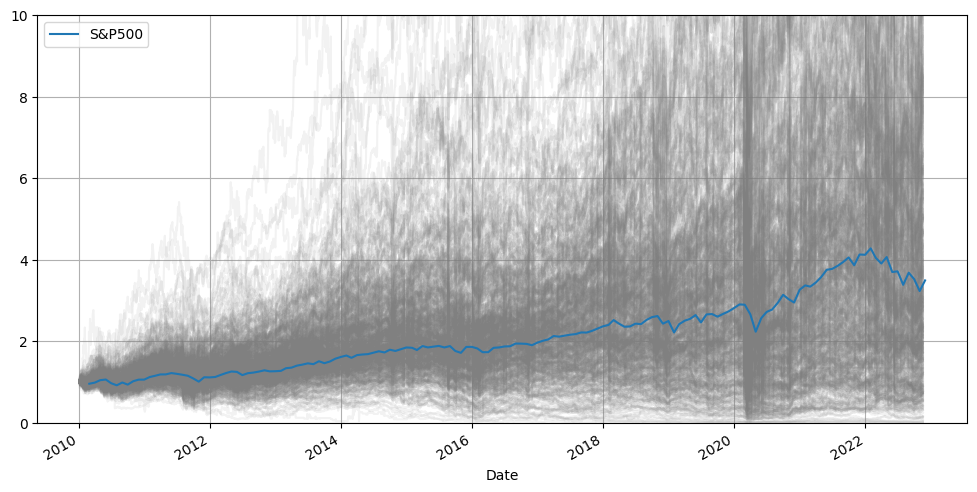

In [11]:
fig, ax = plt.subplots(figsize=[12,6])
returns.plot(ax=ax, color='grey', alpha=0.1, legend=False)
SP500_returns.plot(ax=ax, label = 'S&P500', legend=True)
#ax.set_yscale('log')
#plt.ylabel('returns (log scale)')
plt.ylim([0, 10])
plt.grid()

We can see that many stocks performed much better then the S&P 500 Index!
Is it possible to choose this better stocks?

## Momentum Strategy Idea:
* find best performing stocks durring past window
* buy & hold this stocks durring the next period

In [12]:
class MomentumReturnCalculator:
    def __init__(self, df, windows, min_price=0.01, max_performance=3.):
        """
        INPUT
        df (PandasDataFrame): candle stick data
        windows (vektor): periods of past timeframes 
                 to evaluate for momentum strategy
        min_price (float): minimal allowed price for stocks to buy
        max_performance (float): maximal allowed performance
            durring passt window for stocks to use,
            stocks with performance > max_performance will
            not be considered as valid candidates to buy for next period
            (can be used to exclude suspicious stocks, like meme-stocks) 
        """
        self.windows = windows
        # maximum allowed past performance for symbols to use
        # (reason: remove symbols with cracy performance, likely strange coins)
        self.max_performance = max_performance # e.g 3 -> max 300% ret per month 

        self.min_price = min_price
        
        self.calculate_returns(df)
        self.calculate_window_returns()
            
    def calculate_returns(self, df):
        """calculate returns for whole series"""
        df_open = df.loc[:,pd.IndexSlice[:,'Open']].droplevel(1,axis=1)
        ret_df = df_open.pct_change()
        logret_df = np.log(ret_df + 1)
        self.df = {
            'Open': df_open,
            'ret': ret_df,
            'logret': logret_df
        }

    def calculate_window_returns(self):
        """calculate past log-retunrs and past maximal-returns for all window periods"""
        self.logret_wd = {}
        self.maxret_wd = {}
        for window in self.windows:
            self.logret_wd[window] = self.df['logret'].rolling(window).sum()
            self.maxret_wd[window] = self.df['ret'].rolling(window).max()

    def top_performers(self, top_n, date):
        """find top_n symbols with best past performance durring past windows"""
        # filter to tickers reporting at "current" date
        valid_symbols_date = self.df['Open'].loc[date].dropna().index.to_list()
        # we use only symbols which never were below min_price dollars
        #min_price_until_date = self.df['Open'].loc[:date,valid_symbols_date].min()
        min_price_until_date = self.df['Open'].loc[date,valid_symbols_date]
        valid_symbols = min_price_until_date[min_price_until_date > self.min_price].index
        
        top_performers = {}
        for w in self.windows:
            # filter symbols to performance in past window
            valid_symbols_perf_OK = valid_symbols[np.where(
                self.maxret_wd[w].loc[date, valid_symbols] < self.max_performance)]
            
            top_performers[w] = list(
                self.logret_wd[w].loc[date,valid_symbols_perf_OK
                                     ].nlargest(top_n).dropna().index)

        return(top_performers)
    
    def top_ret(self, top_n, date):
        """get returns of next month, when buying top_n best performers of the last window periods"""
        top_performers = self.top_performers(top_n, date)
        # select returns for top_performers symbols for next period
        perf_ret = pd.Series({
            w: self.df['ret'].loc[date:,top_performers[w]].iloc[1].mean()
            for w in self.windows})
        return(perf_ret)
    
    def get_future_series(self, top_n, date, df_day):
        top_performers = self.top_performers(top_n, date)
        future_series = {}
        for w in self.windows:
            # first trading day of the current month
            i1 = date - MonthBegin(1)
            # first trading day of following month: we have to check df_day for!
            i2 = df_day.loc[datetime.strftime(
                date + MonthBegin(1), '%Y-%m')].index[0]
            next_period_days = df_day.loc[
                i1:i2, (top_performers[w], 'Open')
                ].droplevel(axis=1, level=1)
            future_series[w] = (
                next_period_days.pct_change()+1
                ).cumprod().reset_index(drop=True).T.reset_index(drop=True).T
            # foreward fill of missing values, for case of delisting
            future_series[w] = future_series[w].fillna(method='ffill')
            
        future_series = pd.concat(future_series.values(), keys=future_series.keys(), axis=1)
        future_series = pd.concat([future_series], keys=[date])
        return(future_series)
    
    
def print_profit_stats(profits, SP500_profits):

    profits = profits.dropna()
    SP500_profits = SP500_profits.loc[profits.index[0]:]
    
    SP500_month_avg = SP500_profits.mean()
    SP500_profits_cum = (SP500_profits + 1).cumprod()

    stats_SP500 = pd.DataFrame(
        {
        'total returns': ((SP500_profits + 1).prod() - 1).round(1),
        'average profit [% per month]': str((SP500_month_avg*100).round(1)),
        'average profit [% per year]': (((((SP500_month_avg)+1)**12)-1)*100).round(1),
        'max drawdown [%]': (((SP500_profits_cum / SP500_profits_cum.cummax()) -1).min() * 100).round(1)
        },
        index = ['S&P 500']
    )
    print(stats_SP500.to_string())
    
    print('')
    
    cum_profits = (profits.dropna(axis=0)).cumprod()

    stats = pd.DataFrame(
        {
        'total returns': ((profits.dropna(axis=0)).prod() - 1).round(1),
        'average profit [% per month]': ((profits.dropna(axis=0).mean()-1) * 100).round(1),
        'average profit [% per year]': ((profits.dropna(axis=0).mean()**12 -1)*100).round(1),
        'max drawdown [%]': (((cum_profits / cum_profits.cummax()) -1).min() * 100).round(1)
        }
    )
    print(stats.to_string())

In [13]:
windows = range(1,13)
MRC = MomentumReturnCalculator(df_month, windows, min_price=5., max_performance=1.0)
#windows = range(2,40)
#MRC = MomentumReturnCalculator(df_week, windows, min_price=5., max_performance=0.5)
#windows = range(1,30)
#MRC = MomentumReturnCalculator(df_day, windows, min_price=1., max_performance=0.01)

In [14]:
profits = {}
for date in MRC.df['Open'].index[1:-1]:
    #print(date)
    profits[date] = MRC.top_ret(5, date)
profits = pd.concat(profits.values(), keys=profits.keys(), axis=1).T

In [15]:
print_profit_stats(profits+1, SP500_profits)

         total returns average profit [% per month]  average profit [% per year]  max drawdown [%]
S&P 500            2.3                          0.9                         11.8             -24.5

    total returns  average profit [% per month]  average profit [% per year]  max drawdown [%]
1             3.3                           1.4                         17.8             -49.8
2             7.4                           1.9                         25.6             -41.8
3            13.6                           2.3                         31.9             -45.3
4             9.8                           2.1                         28.1             -34.0
5            14.6                           2.3                         31.8             -30.6
6            16.6                           2.5                         34.0             -37.3
7            25.1                           2.8                         38.5             -32.7
8            66.9                        

Text(0, 0.5, 'returns')

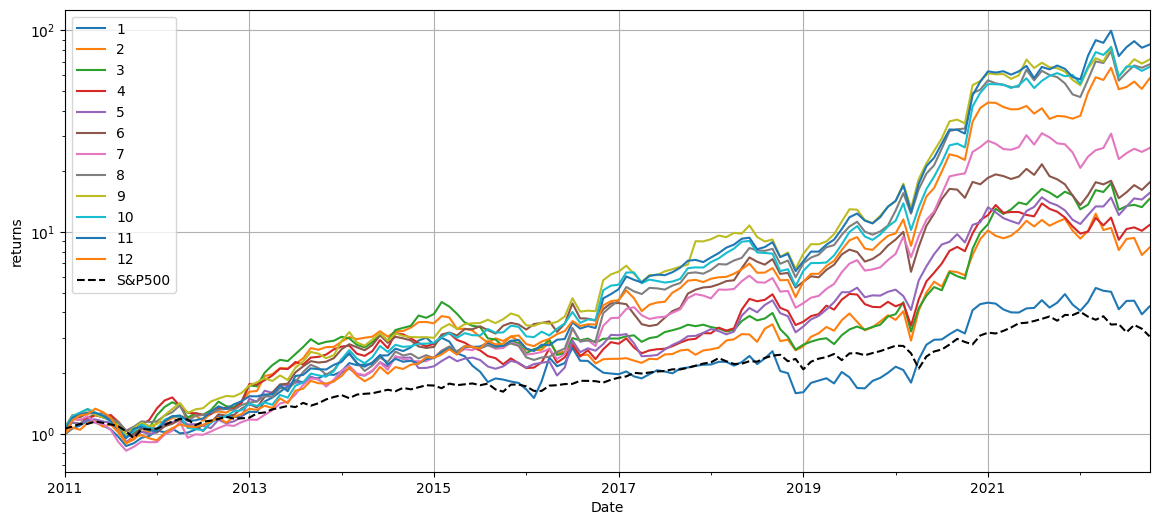

In [16]:
startdate = profits.dropna(axis=0).index[0]
#startdate = '2018-01-01'
#startdate = '2022-01-01'
enddate = profits.dropna(axis=0).index[-1]
fig, ax = plt.subplots(figsize=[14,6]) 
((profits.dropna(axis=0).loc[startdate:enddate] +1).cumprod()).plot(ax=ax)
(SP500_profits.loc[startdate:enddate] + 1).cumprod().plot(ax=ax, linestyle='--', color='black', label = 'S&P500', legend=True)
plt.gca().set_yscale('log')
plt.grid(); plt.legend()
plt.ylabel('returns')
#plt.xlim([startdate, enddate])
#plt.ylim([0,5])

### Yearly returns [%]

In [17]:
returns_year = (profits.dropna(axis=0) + 1).resample('Y').apply(lambda x: x.prod() - 1)
SP500_year = (SP500_profits.dropna(axis=0) + 1).resample('Y').apply(lambda x: x.prod() - 1)
(pd.concat([returns_year, SP500_year.rename('S&P500')], axis=1) * 100).round(1)

,1,2,3,4,5,6,7,8,9,10,11,12,S&P500
2010-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.3
2011-12-31,-2.4,1.9,6.5,17.1,-0.1,7.3,-9.2,14.2,9.4,6.7,4.1,-5.0,5.1
2012-12-31,25.4,41.2,36.2,21.5,21.2,24.3,25.9,21.6,45.7,22.6,39.3,32.1,13.6
2013-12-31,60.1,87.4,99.5,84.6,50.6,77.9,62.5,49.2,53.9,56.2,51.7,45.3,27.6
2014-12-31,53.0,32.9,30.0,3.5,16.5,12.3,23.3,18.4,22.8,36.9,6.9,31.5,14.3
2015-12-31,-40.3,-19.2,-25.2,-17.7,6.0,30.7,20.6,11.2,27.6,21.1,24.4,28.3,0.8
2016-12-31,11.3,-18.8,5.5,27.3,37.5,27.3,35.7,57.1,60.6,60.1,68.6,47.9,5.6
2017-12-31,10.5,10.1,17.1,10.9,2.3,19.9,29.4,45.2,45.7,23.0,44.1,24.4,20.2
2018-12-31,-27.7,0.2,-24.8,9.6,0.6,-0.2,-13.0,-4.0,-26.9,-19.1,-9.8,-15.8,5.5
2019-12-31,26.2,49.1,45.9,30.3,58.9,61.7,72.4,80.6,103.2,97.5,108.8,101.4,12.7


### Distributions of monthly returns

array([[<AxesSubplot: title={'center': '1'}>,
        <AxesSubplot: title={'center': '2'}>,
        <AxesSubplot: title={'center': '3'}>],
       [<AxesSubplot: title={'center': '4'}>,
        <AxesSubplot: title={'center': '5'}>,
        <AxesSubplot: title={'center': '6'}>],
       [<AxesSubplot: title={'center': '7'}>,
        <AxesSubplot: title={'center': '8'}>,
        <AxesSubplot: title={'center': '9'}>],
       [<AxesSubplot: title={'center': '10'}>,
        <AxesSubplot: title={'center': '11'}>,
        <AxesSubplot: title={'center': '12'}>]], dtype=object)

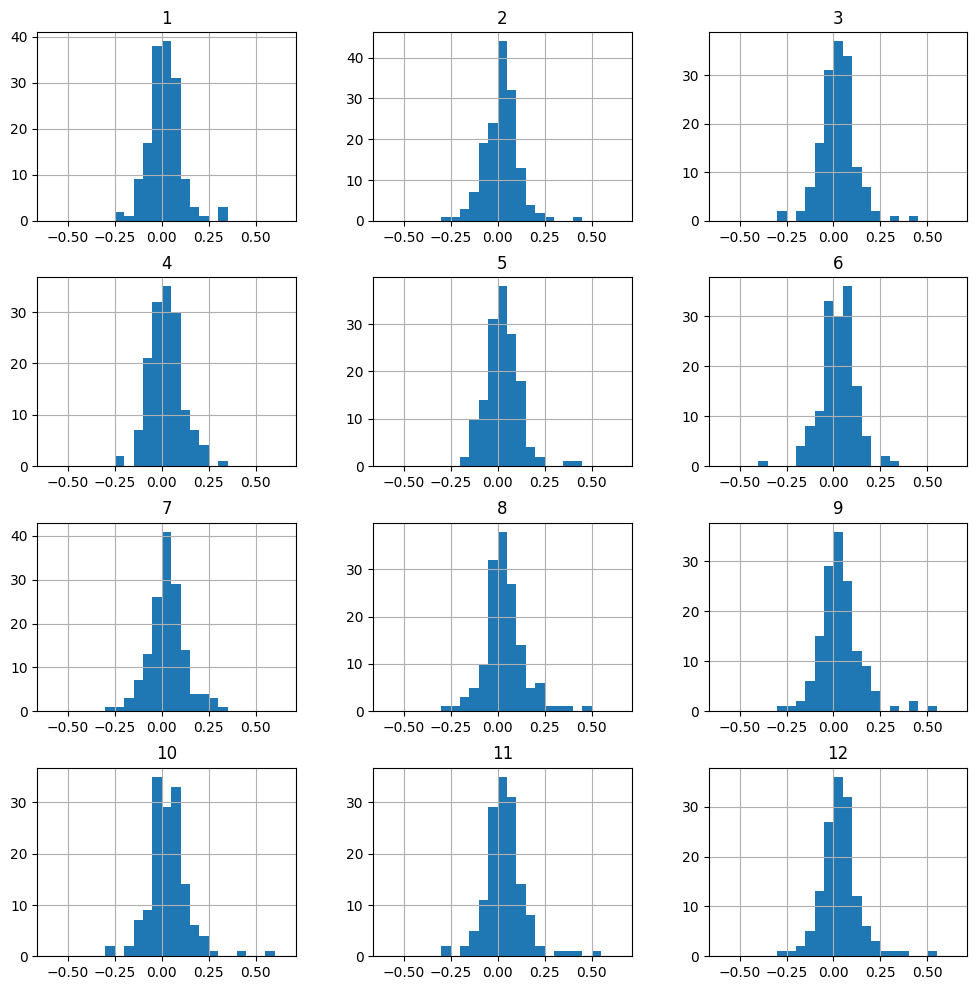

In [18]:
profits.hist(figsize=[12,12], bins=np.arange(-0.6,0.7,0.05))

## Detail analysis of periods in position

In [19]:
future_series = []
for date in MRC.df['Open'].index[1:-1]:
    # print(date)
    future_series.append(MRC.get_future_series(5, date, df_day))
    
future_series = pd.concat(future_series, axis=0)

In [20]:
fs_profits = future_series.dropna()[3].mean(axis=1).groupby(level=0).last()

In [21]:
fs_profits_ = future_series.dropna().groupby(axis=1,level=0).mean().groupby(level=0).last()
(fs_profits_).prod()#.plot()

1      4.458299
2      8.482584
3     14.811821
4     10.857002
5     15.644469
6     17.636889
7     26.144959
8     67.861177
9     71.735105
10    65.897334
11    85.081348
12    57.837482
dtype: float64

In [22]:
from scipy import interpolate
def stretch_series(s):
    # stretch series to whole month (30 days)
    s = s.dropna()
    #new_xrange = (s.index-1) * 29/s.index[-2] + 1
    new_xrange = s.index * 30/s.index[-1]
    f = interpolate.interp1d(new_xrange, s.values)
    #x_target = np.arange(1,31)
    x_target = np.arange(0,31)
    s_new = pd.Series(index=x_target, data=f(x_target))
    return(s_new)

In [23]:
future_series.index.names = ['month', 'day']
future_series.columns.names = ['window', 'stock']

In [24]:
future_series_ = future_series.copy()
future_series_ = future_series_.loc[future_series_.dropna().first_valid_index()[0]:]
# set 0ths day of series to 1
future_series_.loc[pd.IndexSlice[:,0],:] = 1

In [25]:
future_series_ = future_series_.unstack(0)

In [26]:
future_series_ = future_series_.apply(stretch_series)
future_series_ = future_series_.stack(2).swaplevel().sort_index()

In [27]:
stocks_mean = future_series_.pct_change().groupby(axis=1, level=0).mean()
stocks_mean_month = stocks_mean.groupby(level=1).mean()
stocks_mean.loc[pd.IndexSlice[:,0],:] = np.nan

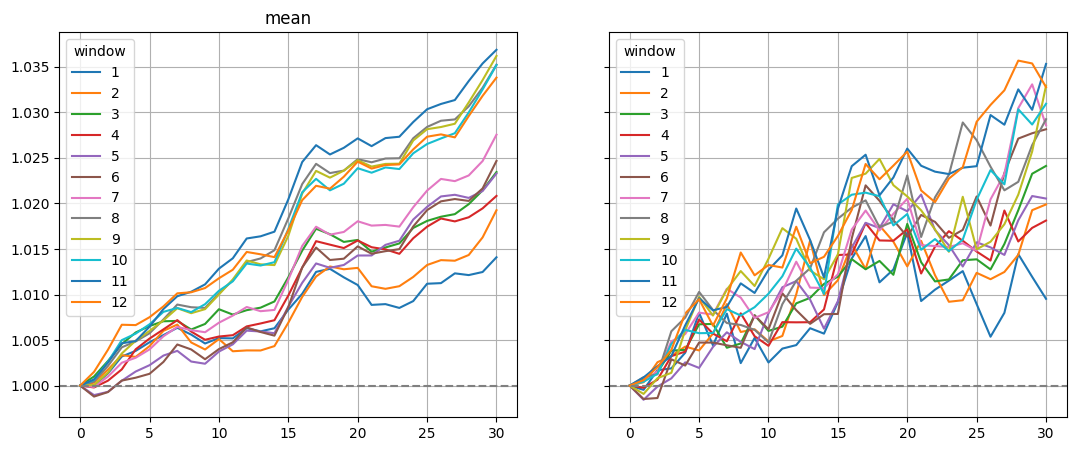

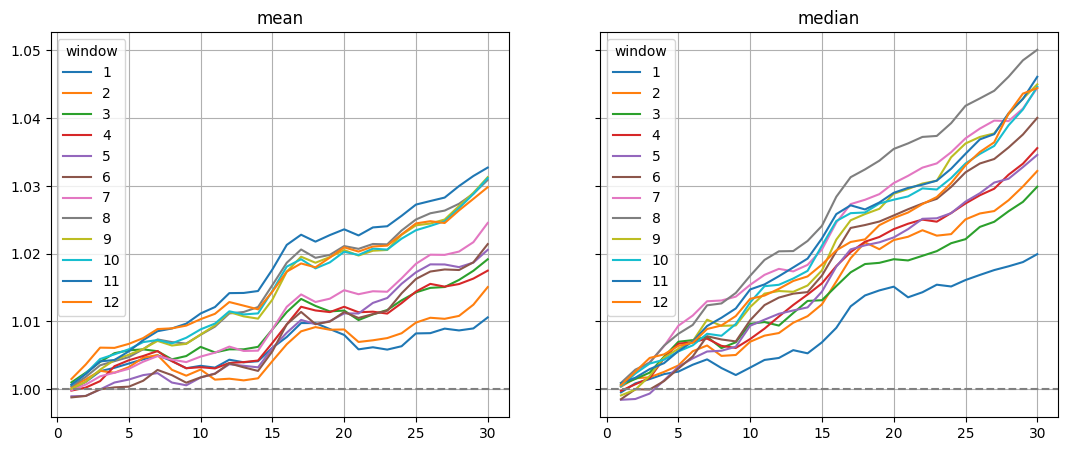

In [28]:



# method 1: average accumulated returns per perios
# average all stocks parallel in trades
stocks_mean = future_series_.groupby(axis=1, level=0).mean()

fig, axs = plt.subplots(1,2, figsize=[13,5], sharey=True)
# mean of all month
stocks_mean_month = stocks_mean.groupby(level=1).mean()
stocks_mean_month.plot(ax=axs[0])

axs[0].set_title('mean')
# median of all month
stocks_mean_month_median = stocks_mean.groupby(level=1).median()
stocks_mean_month_median.plot(ax=axs[1])

for ax in axs:
    ax.grid()
    ax.axhline(1, linestyle='--', color='grey')


#==================================================================
    
# method 2: average pct changes!
# average all stocks parallel in trades
stocks_mean = future_series_.pct_change().groupby(axis=1, level=0).mean()
# first day of pct change is not valid, since break in dataset!!!
stocks_mean.loc[pd.IndexSlice[:,0],:] = np.nan



fig, axs = plt.subplots(1,2, figsize=[13,5], sharey=True)
# mean of all month
stocks_mean_month = stocks_mean.groupby(level=1).mean()
(stocks_mean_month+1).cumprod().plot(ax=axs[0])

axs[0].set_title('mean')
# median of all month
stocks_mean_month_median = stocks_mean.groupby(level=1).median()
(stocks_mean_month_median+1).cumprod().plot(ax=axs[1])
axs[1].set_title('median')


for ax in axs:
    ax.grid()
    ax.axhline(1, linestyle='--', color='grey')


In [29]:
data_flat = future_series_.stack().stack().reset_index()
data_flat.columns = ['month', 'day', 'stock', 'window', 'value']

<AxesSubplot: xlabel='day', ylabel='value'>

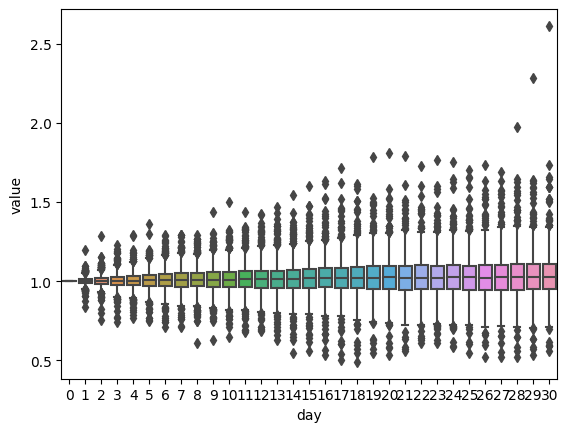

In [30]:
import seaborn as sns
sns.boxplot(data=data_flat.query('window == 11'), x='day', y='value')

In [31]:
performance_10days = (future_series_.loc[pd.IndexSlice[:,10],:].groupby(level=0).mean() - 1)*100
performance_total = (future_series_.groupby(level=0).last() - 1)*100

(-50.0, 100.0)

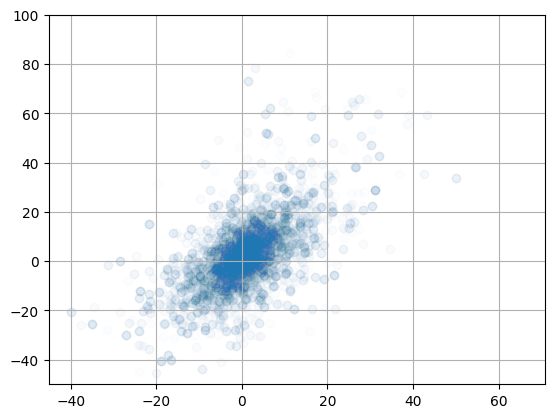

In [32]:
plt.scatter(performance_10days, performance_total, alpha=0.01)
plt.grid()
plt.ylim([-50, 100])


## Stop loss

In [33]:
# we have here only "open" data for each day!
# if open is < stop_loss, we sell for open price
# ... this could lead to a pessimistic result, since we could have closed already durring pervious intrady trading
stop_loss = 0.90
future_series_valid = future_series.dropna()
last = future_series_valid.groupby(level=0).last()
tmp = future_series_valid.unstack(0)
tmp_filter = (tmp > stop_loss).shift().fillna(True)
returns_stock = tmp[(tmp_filter).cummin()].ffill().iloc[-1]
profits = returns_stock.unstack(1).mean(axis=1).unstack(0)


print_profit_stats(profits, SP500_profits)

         total returns average profit [% per month]  average profit [% per year]  max drawdown [%]
S&P 500            2.3                          0.9                         11.8             -24.5

        total returns  average profit [% per month]  average profit [% per year]  max drawdown [%]
window                                                                                            
1                 2.6                           1.2                         15.3             -49.8
2                 6.8                           1.8                         23.7             -45.7
3                10.3                           2.1                         28.0             -42.0
4                 5.4                           1.7                         22.0             -38.4
5                 4.9                           1.6                         21.3             -35.2
6                 6.8                           1.8                         24.0             -39.3
7        

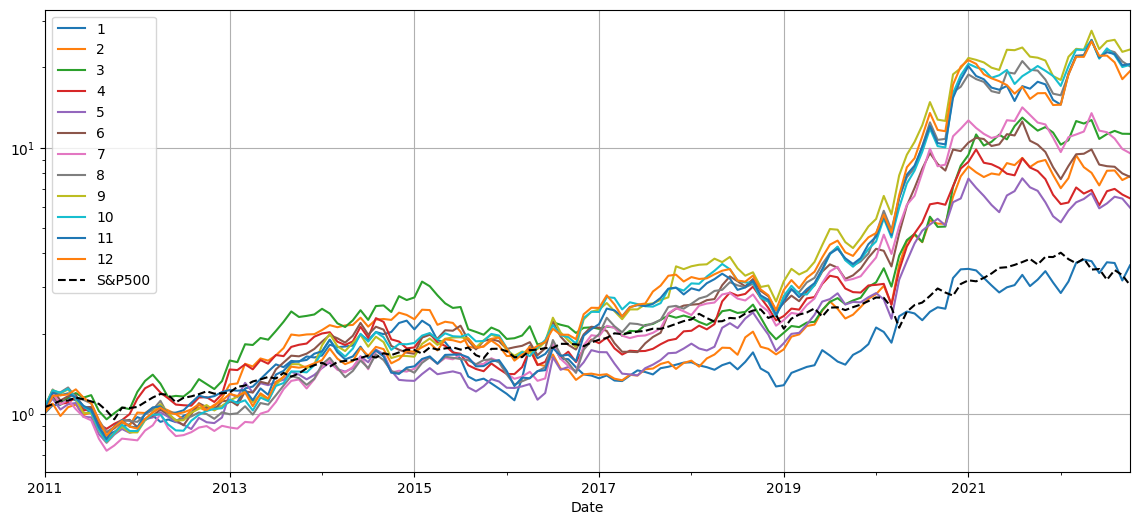

In [34]:
startdate = profits.dropna(axis=0).index[0]
#startdate = '2018-01-01'
#startdate = '2022-01-01'
enddate = profits.dropna(axis=0).index[-1]
fig, ax = plt.subplots(figsize=[14,6]) 
profits.cumprod().plot(ax=ax)
(SP500_profits.loc[startdate:enddate] + 1).cumprod().plot(ax=ax, linestyle='--', color='black', label = 'S&P500', legend=True)
plt.gca().set_yscale('log')
plt.grid(); plt.legend()


In [35]:
# optimistic method:
# we assume that we could close the postion always exactly for stop_loss 
stop_loss = 0.95
future_series_valid = future_series.dropna()
last = future_series_valid.groupby(level=0).last()
low = future_series_valid.groupby(level=0).min()
rets = pd.DataFrame(data=np.where(low < stop_loss, stop_loss, last), index=last.index, columns=last.columns)
profits = rets.groupby(axis=1, level=0).mean()


print_profit_stats(profits, SP500_profits)

         total returns average profit [% per month]  average profit [% per year]  max drawdown [%]
S&P 500            2.3                          0.9                         11.8             -24.5

        total returns  average profit [% per month]  average profit [% per year]  max drawdown [%]
window                                                                                            
1                 6.0                           1.5                         20.3             -28.0
2                25.6                           2.6                         35.4             -19.0
3                32.4                           2.7                         38.2             -15.0
4                27.0                           2.6                         35.8             -16.3
5                17.1                           2.3                         31.2             -23.8
6                24.0                           2.5                         34.6             -26.1
7        

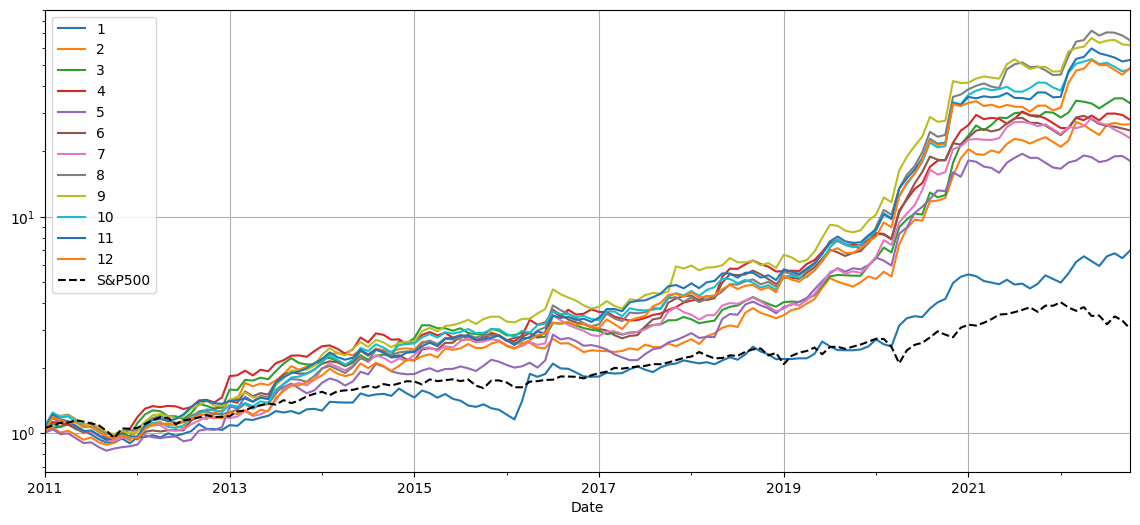

In [36]:
startdate = profits.dropna(axis=0).index[0]
#startdate = '2018-01-01'
#startdate = '2022-01-01'
enddate = profits.dropna(axis=0).index[-1]
fig, ax = plt.subplots(figsize=[14,6]) 
profits.cumprod().plot(ax=ax)
(SP500_profits.loc[startdate:enddate] + 1).cumprod().plot(ax=ax, linestyle='--', color='black', label = 'S&P500', legend=True)
plt.gca().set_yscale('log')
plt.grid(); plt.legend()
